In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qutip import basis, tensor, sigmax, mesolve, Bloch, Qobj

from util import pretty, mask_small_values

# Analog Quantum Computing

In this notebook, we'll introduce **analog quantum computing**. That is, we will peak underneath the hood of the gate-based model of quantum computing (QC) to understand a bit more what underlying physical process gives rise to QC. In breaking the abstraction layer that separates abstract computation from the quantum mechanics, we would find that the underlying ``implementation" is given by **Schrödinger's Equation**. First, we begin with a brief review of **qubits**.

## Review: Gate-Based Quantum Computing

We'll briefly review gate-based QC, including qubits and unitary evolution.

### Qubits

We can think of a **qubit** as a unit of quantum information similar to how a bit is a unit of classical information. A **quantum state** with $n$ qubits of information, notated $\ket{q_{n-1} \dots q_0}$ where $q_i \in \{ 0, 1\}$, can thus be encoded as an element of 

$$
\mathcal{Q}(n) := \{ v \in \mathbb{C}^{N} : \lVert v \rVert = 1\}
$$

where $N = 2^n$. We give some examples of elements of $\mathcal{Q}(1)$ now.

In [2]:
# Example: |0>
zero = basis(2, 0)
pretty(zero)

<IPython.core.display.Latex object>

In [3]:
# Example: |1>
one = basis(2, 1)
pretty(one)

<IPython.core.display.Latex object>

In [4]:
# Example: |+>
plus = 1/np.sqrt(2) * (zero + one)
pretty(plus)

<IPython.core.display.Latex object>

In [5]:
# Example: |->
minus = 1/np.sqrt(2) * (zero - one)
pretty(minus)

<IPython.core.display.Latex object>

#### Bloch Sphere Visualization

With a single qubit, we can use the Bloch sphere to visualize the quantum state.

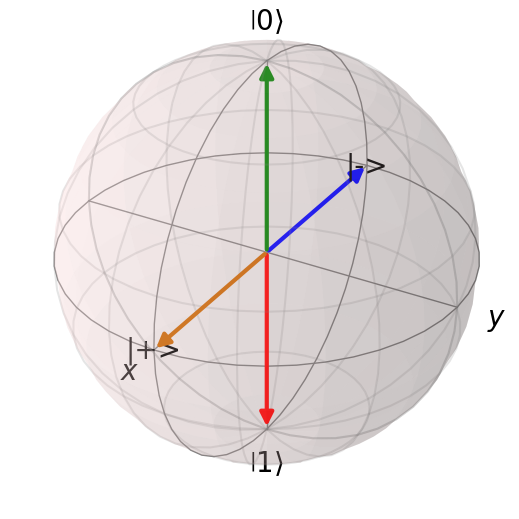

In [6]:
b = Bloch()
b.add_states(zero)
b.add_states(plus)
b.add_annotation(plus, "|+>")
b.add_states(minus)
b.add_annotation(minus, "|->")
b.add_states(one)
b.show()

#### Multi-Qubit Systems

We give some examples of elements of $\mathcal{Q}(2)$ below.

In [7]:
# |00>
zz = tensor(zero, zero)
pretty(zz)

<IPython.core.display.Latex object>

In [8]:
# |11>
oo = tensor(one, one)
pretty(oo)

<IPython.core.display.Latex object>

The Bell state gives an example of an **entangled** quantum state.

In [9]:
# Bell State
bell = 1/np.sqrt(2) * (zz + oo)
pretty(bell)

<IPython.core.display.Latex object>

### Unitary Evolution

In a gate-based formulation of QC, we perform computations on quantum states by applying a quantum circuit (comprised of quantum gates) to a quantum state. Abstractly, we can write this as

$$
U\ket{\psi_\text{initial}} = \ket{\psi_\text{final}}
$$

where $U$ is the $N \times N$ unitary matrix corresponding to the quantum circuit, $\ket{\psi_\text{initial}} \in \mathcal{Q}(n)$ is the inital quantum state, and $\ket{\psi_\text{final}} \in \mathcal{Q}(n)$ is the resulting quantum state. The formulation of QC via quantum circuit enables us to abstract away the underlying quantum mechanics and think purely in terms of unitary transformations.

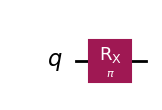

In [10]:
q_zero = Statevector(np.array([1.0, 0.0]))
q_one = Statevector(np.array([0.0, 1.0]))

qc = QuantumCircuit(1)
qc.rx(np.pi, 0)
qc.draw(output="mpl")

In [11]:
# Unitary evolution is given by matrix multiplication
pretty(q_zero.evolve(Operator(qc)).data)

<IPython.core.display.Latex object>

In [12]:
# Unitary evolution is given by matrix multiplication
pretty(q_one.evolve(Operator(qc)).data)

<IPython.core.display.Latex object>

## Time Evolution with Schrödinger's Equation

Our goal in this notebook is peak underneath the hood of a quantum gate to understand a bit more what is going on behind in the scenes. In doing so, we will encounter **Schrödinger's equation** instead which governs the time-evolution of a quantum system. Schrödinger's equation for quantum systems encoding $n$ qubits of information is

$$
\hat{H} \ket{\psi(t)} = i\hbar\frac{d}{d t} \ket{\psi(t)}
$$

where $\ket{\psi(t)} \in \mathcal{Q}(n)$ is a quantum state and $\hat{H}$ is a **Hamiltonian** encoding the total energy of a quantum system. We will discuss the Hamiltonian next.

### Hamiltonian

We can represent a Hamiltonians $\hat{H}$ on $n$ qubit systems with a $2^N \times 2^N$ **Hermitian matrices** $H$. As a reminder, a matrix $H$ is **Hermitian** if

$$
H = H^\dagger \,.
$$

#### Pauli Hamiltonian $\sigma_x$

Our first example of a Hamiltonian $\sigma_x$ corresponds to the Pauli-X gate, i.e., a rotation around the $x$-axis on a Bloch sphere.

In [13]:
sigma_x = sigmax()
pretty(sigma_x.full())

<IPython.core.display.Latex object>

In [14]:
np.allclose(sigma_x.full(), np.conjugate(sigma_x.full()).T)

True

##### Warning

The Hamiltonian Pauli-X gate is identical to the unitary matrix corresponding to the X gate.

### Time-Evolution

To determine the quantum state $\ket{\psi(t)}$ at time $t$ of a quantum system whose total energy is given by $\hat{H}$, we solve Schrödinger's equation, reproduced below, 

$$
\hat{H} \ket{\psi(t)} = i\hbar\frac{d}{d t} \ket{\psi(t)} \,.
$$

In the case where the Hamiltonian $H$ is time-independent,

$$
\ket{\psi(t)} = \exp(-iH(t - t_0)/\hbar)\ket{\psi(t_0)}
$$

for any $t_0$ is a solution to Schrödinger's equation since

\begin{align*}
i\hbar \frac{d}{dt} \ket{\psi(t)} & = i\hbar \frac{d}{dt} \left( \exp(-iH(t - t_0)/\hbar)\ket{\psi(t_0)} \right) \tag{subst solution} \\
& = H \exp(-iH(t - t_0)/\hbar)\ket{\psi(t_0)} \tag{derivative} \\
& = H \ket{\psi(t)} \tag{subst solution} \,.
\end{align*}

#### RX Gate

This suggests that if we simulate Schrödinger's equation under $\sigma_x$ for some time $T$ starting at $t_0$ where $\ket{\psi(t_0)} = \ket{0}$, we can flip $\ket{0}$ to $-i\ket{1}$ as we might expect an $RX$ gate for $\pi$ radians to do.

In [15]:
# Simulate the evolution of |0> under the X Hamiltonian from T = pi/2
times = np.linspace(0, np.pi/2, 500)
result = mesolve(sigma_x, zero, times, [], [])
result

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 9.107589721679688e-05
    preparation time: 6.413459777832031e-05
    run time: 0.006517887115478516
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 1.5707963267948966] (500 steps)
  Number of e_ops: 0
  States saved.
>

In [16]:
final_state = result.states[-1]
pretty(final_state)

<IPython.core.display.Latex object>

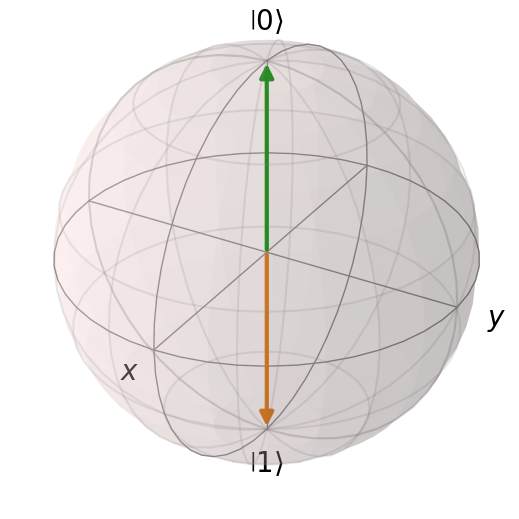

In [17]:
b = Bloch()
b.add_states(zero)
b.add_states(final_state)
b.show()

#### Periodic Behavior

For a time-independent Hamiltonian, we should expect periodic behavior. This essentially encodes the idea that quantum computations are reversible since they can always be "undone" by waiting for enough time until we hit our initial state.

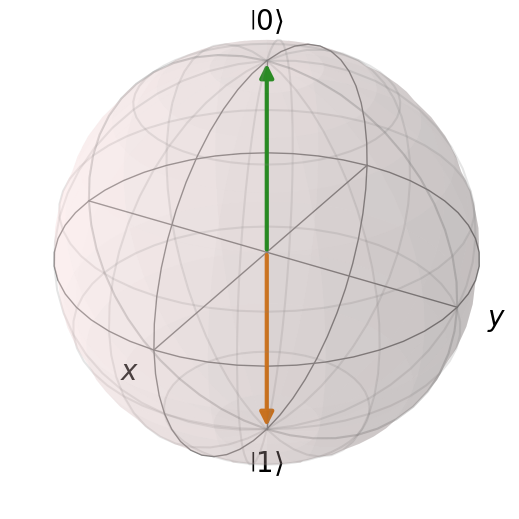

In [18]:
# Simulate the evolution under the Pauli-X gate
times = [0, 3*np.pi/2]  # Start at t=0, end at t=pi/2
result = mesolve(sigma_x, zero, times, [], [])
final_state2 = result.states[-1]
b = Bloch()
b.add_states(zero)
b.add_states(final_state2)
b.show()

### Connection with the Gate-Based Model

How do we obtain the corresponding gate from a given Hamiltonian $H$? Observe that

$$
\ket{\psi(t)} = \exp(-iH(t - t_0))\ket{\psi(t_0)}
$$

is a solution for a time-independent Hamiltonian $H$. Thus, we can introduce a definition $U_{t, t_0}$ so that

\begin{align*}
\ket{\psi(t)} & = \exp(-iH(t - t_0))\ket{\psi(t_0)} \tag{solution} \\
& = U_{t, t_0}\ket{\psi(t_0)} \tag{definition}
\end{align*}

to recover the more familiar unitary evolution of a quantum state. In words, simulating the quantum system with initial quantum state
$\ket{\psi(t_0)}$ for time $t - t_0$ under the time-independent Hamiltonian $H$ is equivalent to the application of a quantum gate corresponding to the unitary matrix $U_{t, t_0}$.

In [19]:
# Compute the matrix exponential
RX_pi_gate = (-1j * sigma_x * np.pi/2).expm()
pretty(RX_pi_gate.full())

<IPython.core.display.Latex object>

Thus the corresponding gate for the Pauli-X Hamiltonian $\sigma_x$ is the $RX(\theta)$ gate applied for $\pi$ radians:

\begin{align*}
\exp(-i (\theta/2) \sigma_x) & = \begin{pmatrix}
\cos(\theta/2) & -i \sin(\theta/2) \\
-i \sin(\theta/2) & \cos(\theta/2)
\end{pmatrix} \\
& = RX(\theta) \,.
\end{align*}

In [20]:
pretty(RX_pi_gate @ zero)

<IPython.core.display.Latex object>

#### Case: Time-Dependent Hamiltonian

More generally, the corresponding unitary matrix obtained as

$$
U_{t_1, t_0} = \mathcal{T} \exp \left( -i \int_{t_0}^{t_1} H(t) dt \right)
$$

where $\mathcal{T} \exp$ is the time-ordered matrix exponential gives the corresponding unitary matrix for a given time-dependent Hamiltonian $H(t)$.

### The CNOT "Gate"

We'll now construct a Hamiltonian that corresponds to a CNOT (CZ) gate.

In [21]:
minus = 1/np.sqrt(2)*(zero - one)
H_cnot = Qobj(np.outer(tensor(one, minus).full(), tensor(one, minus).full()), dims=[[2, 2], [2, 2]])
pretty(H_cnot.full())

<IPython.core.display.Latex object>

In [22]:
times = np.linspace(0, np.pi, 500)
result = mesolve(H_cnot, tensor(zero, zero), times, [], [])
final_state3 = result.states[-1]

# |00> -> |00>
pretty(final_state3)

<IPython.core.display.Latex object>

In [23]:
times = np.linspace(0, np.pi, 500)
result = mesolve(H_cnot, tensor(zero, one), times, [], [])
final_state3 = result.states[-1]

# |01> -> |01>
pretty(final_state3)

<IPython.core.display.Latex object>

In [24]:
times = np.linspace(0, np.pi, 500)
result = mesolve(H_cnot, tensor(one, zero), times, [], [])
final_state3 = result.states[-1]

# |10> -> |11>
pretty(mask_small_values(final_state3))

<IPython.core.display.Latex object>

In [25]:
times = np.linspace(0, np.pi, 500)
result = mesolve(H_cnot, tensor(one, one), times, [], [])
final_state3 = result.states[-1]

# |11> -> |10>
pretty(mask_small_values(final_state3))

<IPython.core.display.Latex object>

In [26]:
# Get the unitary evolution (CNOT gate) from the Hamiltonian
U_cnot = (-1j * H_cnot * np.pi).expm()
pretty(mask_small_values(U_cnot).full())

<IPython.core.display.Latex object>

## Summary

1. We reviewed gate-based QC which performs computation on quantum states via unitary transformations.
2. We saw how unitary transformations were implemented as evolution of a quantum state under a Hamiltonian governed by Schrödinger's equation.

## Appendix: Quantum Mechanics

The presentation of Schrödinger's equation that we have given is not the most concrete form that we can give it in. Physically, a quantum system will be comprised of particles (e.g., atoms, electrons, etc.) that influence each other according to quantum mechanics, i.e., a physically meaningful form of Schrödinger's equation. We'll present the physically menaingful form of Schrödinger's equation in more detail now and connect it back to the abstract formulation given earlier.

### Quantum System

Quantum mechanics describe the time evolution of **quantum systems**. A quantum system is described by
1. a **wave function** encoding the **quantum state** of particles (e.g., electrons) comprising the quantum system,
2. a **Hamiltonian** encoding the total energy of the quantum system, and 
3. **Schrödinger's Equation** which relates the wave function with the Hamiltonian.

We'll describe these components in more detail now.

#### Wave Function

A **wave function** 

$$
\psi(x, t): \mathbb{R}^3 \times \mathbb{R} \rightarrow \mathbb{C}
$$

encodes the quantum state of a particle (or collections of particles). It is a complex-valued function that satisfies 

$$
\int | \psi(x, t) |^2 dx = 1
$$

for any time $t \in \mathbb{R}$. The quantity $|\psi(x, t)|^2$ can be interpreted as the probability of finding the particle at position $x \in \mathbb{R}^3$.

#### Hamiltonian

A Hamiltonian $\hat{H}$ is an **operator** (i.e., linear functional) that describes the total kinetic and potential energy of a system. More concretely, a Hamiltonian acts on a wave function $\psi(x, t)$ to produce an energy, written

$$
\hat{H} \psi(x, t) \,.
$$

#### Schrödinger's Equation

The **(time-dependent) Schrödinger Equation** is given by the equation

$$
\hat{H} \psi(x, t) = -i\hbar \frac{\partial}{\partial t} \psi(x, t)
$$

where $\psi(x, t)$ is a wave function, $\hat{H}$ is a Hamiltonian, and $\hbar$ is reduced Planck's constant.

##### Aside: Time-Independent Schrödinger's Equation

The **(time-independent) Schrödinger Equation** is given by the equation

$$
\hat{H} \psi(x) = i\hbar \psi(x)
$$

where $\psi(x)$ is a wave function, $\hat{H}$ is a Hamiltonian, and $\hbar$ is reduced Planck's constant. In this form, we can see that valid wave functions $\psi(x)$ are eigenvectors of $\hat{H}$. The ground state of such a quantum system thus corresponds to the eigenvector with the lowest eigenvalue, i.e., energy. Electronic-structure calculations thus solve an eigenvalue problem.

### Abstract Formulation of Schrödinger's Equation

If we are willing to trade physically meaningful for computational convenience, we may adopt Bra-Ket notation to abstract the wave function. In particular, define

$$
\psi(x, t) = \langle x | \psi(t) \rangle
$$

where

1. $\bra{x}$ is a **bra** corresponding to the position basis and 
2. $\ket{\psi(t)}$ is a **ket** defined as

$$
\ket{\psi(t)} = \int \psi(x, t) \ket{x} dx \,.
$$

We can rewrite Schrödinger's equation more abstractly in Bra-Ket notation as

$$
\hat{H} \ket{\psi(t)} = i\hbar\frac{d}{d t} \ket{\psi(t)} \,.
$$

In this way, we have encoded the quantum state of a quantum system in $\ket{\psi(t)}$. 


Notably, we gain computational convenience that enables us to reason at the level of quantum states and changes in quantum state. However, we lose the physically meaningful notion of a particle. 